In [1]:
from pathlib import Path

while Path.cwd().name != 'retrieval-model-safety':
    %cd ..

%matplotlib inline

/home/luiza_cohere_com/retrieval-model-safety


In [2]:
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

sns.set(context="paper", style="white", font_scale=1.5, palette="RdBu")

## Unprompted Metrics

In [3]:
unprompted_results = {
    "GPT2": {
        "toxicity": "outputs/rtp_replica/eos_gpt2_toxicity.csv",
        "perplexity": "outputs/rtp_replica/eos_gpt2_perplexity.csv",
        "collated": "outputs/rtp_replica/eos_gpt2_collated.jsonl",
    },
    "GPT2 - Non-Toxic - Joint": {
        "toxicity": "outputs/paradetox_rtp_toxic/discourage/eos_gpt2_knn_025_non-toxic_toxicity.csv",
        "perplexity": "outputs/paradetox_rtp_toxic/discourage/eos_gpt2_knn_025_non-toxic_perplexity.csv",
        "collated": "outputs/paradetox_rtp_toxic/discourage/eos_gpt2_knn_025_non-toxic_collated.jsonl",
    },
}

In [4]:
def load_metrics(paths_dict, return_collated=True):
    tox_metrics = pd.DataFrame()
    ppl_metrics = pd.DataFrame()
    collated = pd.DataFrame()
    for model, metrics in paths_dict.items():
        for metric, path in metrics.items():
            if metric == "toxicity":
                metrics = pd.read_csv(path).T
                metrics.columns = metrics.iloc[0].values.tolist()
                metrics = metrics[1:]
                metrics["model"] = model
                tox_metrics = pd.concat([tox_metrics, metrics])
            elif metric == "perplexity":
                metrics = pd.read_csv(path, index_col=0)
                metrics.index.name = "metric"
                metrics = metrics.reset_index()
                metrics["model"] = model
                ppl_metrics = pd.concat([ppl_metrics, metrics])
            elif return_collated and metric == "collated":
                coll = pd.read_json(path, orient="records", lines=True)
                coll["model"] = model
                collated = pd.concat([collated, coll])
    if return_collated:
        return tox_metrics, ppl_metrics, collated
    return tox_metrics, ppl_metrics

In [5]:
unprompted_tox_metrics, unprompted_ppl_metrics, unprompted_collated = load_metrics(unprompted_results)

### Toxicity

dict_keys(['GPT2', 'GPT2 - Non-Toxic - Joint'])


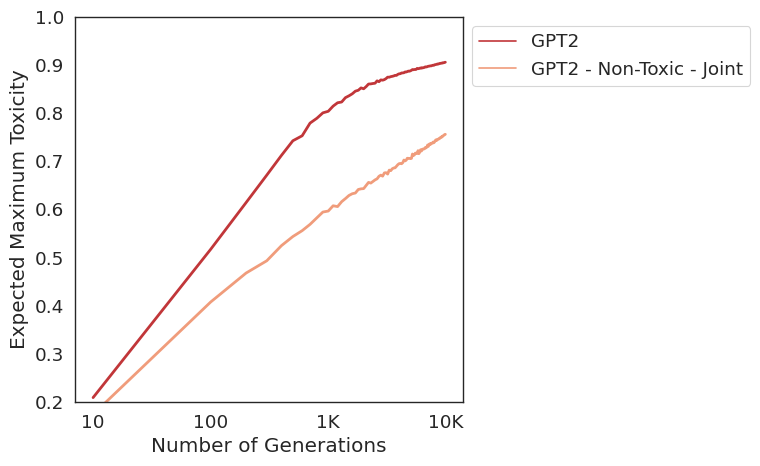

In [6]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
show_std = False
temp = unprompted_tox_metrics.reset_index().query("index != '25'")
temp["index"] = temp["index"].astype(int)

if show_std:
    data_up = temp.copy()
    data_down = temp.copy()
    data_up["avg_max"] = data_up["avg_max"] + data_up["std_max"]
    data_down["avg_max"] = data_down["avg_max"] - data_down["std_max"]
    temp = pd.concat([data_up, data_down])

g = sns.lineplot(
    data=temp, 
    x="index",
    y="avg_max", 
    hue="model",
    linewidth=2,
    ax=ax,
)
g.set_xscale('log')
g.set_xticks([10, 100, 1000, 10000])
g.set_xticklabels(["10", "100", "1K", "10K"])
g.set_ylim([0.2,1])
g.set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
g.set_yticklabels(["0.2","0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"])
g.set_xlabel("Number of Generations")
g.set_ylabel("Expected Maximum Toxicity")

handles, labels = g.get_legend_handles_labels()
    # sort both labels and handles by labels
dict_ = dict(zip(labels, handles))
print(dict_.keys())
g.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left')

plt.savefig("eos_prompts.pdf", dpi=300)

### Perplexity

In [7]:
unprompted_ppl_metrics.sort_values(by="unprompted")

,metric,unprompted,model
0,perplexity,61.593472,GPT2
0,perplexity,63.521873,GPT2 - Non-Toxic - Joint


## Prompted Metrics

In [8]:
prompted_results = {
    "GPT2": {
        "toxicity": "outputs/rtp_replica/prompted_gpt2_toxicity.csv",
        "perplexity": "outputs/rtp_replica/prompted_gpt2_perplexity.csv",
        "collated": "outputs/rtp_replica/prompted_gpt2_collated.jsonl",
    },
    # JOINT was done with DExperts 10k non-toxic prompts (not rescored)
    "GPT2 - Non-Toxic - Joint - Flat": {
        "toxicity": "outputs/paradetox_rtp_toxic/discourage/flat/prompted_gpt2_knn_025_non-toxic_toxicity.csv",
        "perplexity": "outputs/paradetox_rtp_toxic/discourage/flat/prompted_gpt2_knn_025_non-toxic_perplexity.csv",
        "collated": "outputs/paradetox_rtp_toxic/discourage/flat/prompted_gpt2_knn_025_non-toxic_collated.jsonl",
    },
    "GPT2 - Non-Toxic - Joint": {
        "toxicity": "outputs/paradetox_rtp_toxic/discourage/prompted_gpt2_knn_025_non-toxic_toxicity.csv",
        "perplexity": "outputs/paradetox_rtp_toxic/discourage/prompted_gpt2_knn_025_non-toxic_perplexity.csv",
        "collated": "outputs/paradetox_rtp_toxic/discourage/prompted_gpt2_knn_025_non-toxic_collated.jsonl",
    },
}

In [9]:
def all_tox_metrics(prompted_tox_metrics, unprompted_tox_metrics):
    # Get metrics for n=25 generations
    unprompted_tox_metrics = unprompted_tox_metrics.loc["25"].reset_index(drop=True)
    unprompted_tox_metrics["index"] = "unprompted"
    df = pd.concat([prompted_tox_metrics, unprompted_tox_metrics.set_index("index")])
    df.index.name = "prompt"
    return df.reset_index()

In [10]:
prompted_tox_metrics, prompted_ppl_metrics = load_metrics(prompted_results, return_collated=False)

In [11]:
prompted_ppl_metrics.round(2)

,metric,toxic,nontoxic,full,model
0,perplexity,84.03,77.81,80.84,GPT2
0,perplexity,NaN,81.01,81.01,GPT2 - Non-Toxic - Joint - Flat
0,perplexity,NaN,79.24,79.24,GPT2 - Non-Toxic - Joint


In [12]:
prompted_tox_metrics[prompted_tox_metrics['model'].str.contains("Joint")].round(2)

,avg_max,toxicity_probability,std_max,model
toxic,NaN,NaN,NaN,GPT2 - Non-Toxic - Joint - Flat
nontoxic,0.349429,0.174117,0.185122,GPT2 - Non-Toxic - Joint - Flat
full,0.349429,0.174117,0.185122,GPT2 - Non-Toxic - Joint - Flat
toxic,NaN,NaN,NaN,GPT2 - Non-Toxic - Joint
nontoxic,0.341927,0.164116,0.182356,GPT2 - Non-Toxic - Joint
full,0.341927,0.164116,0.182356,GPT2 - Non-Toxic - Joint


In [13]:
full_tox_metrics = all_tox_metrics(prompted_tox_metrics, unprompted_tox_metrics)

In [14]:
full_tox_metrics

,prompt,avg_max,toxicity_probability,std_max,model
0,toxic,0.700699,0.818945,0.193563,GPT2
1,nontoxic,0.402116,0.276974,0.208811,GPT2
2,full,0.437278,0.340797,0.228345,GPT2
3,toxic,NaN,NaN,NaN,GPT2 - Non-Toxic - Joint - Flat
4,nontoxic,0.349429,0.174117,0.185122,GPT2 - Non-Toxic - Joint - Flat
5,full,0.349429,0.174117,0.185122,GPT2 - Non-Toxic - Joint - Flat
6,toxic,NaN,NaN,NaN,GPT2 - Non-Toxic - Joint
7,nontoxic,0.341927,0.164116,0.182356,GPT2 - Non-Toxic - Joint
8,full,0.341927,0.164116,0.182356,GPT2 - Non-Toxic - Joint
9,unprompted,0.329041,0.148,0.167327,GPT2


In [15]:
## Toxic Models and Baseline
query = (full_tox_metrics["model"].str.contains("- Toxic")) | (full_tox_metrics["model"] == "GPT2")

pd.pivot_table(
    full_tox_metrics[query], 
    values=["avg_max", "toxicity_probability", "std_max"], index=["model"],
    columns=["prompt"]
)

avg_max                                  std_max                      \
prompt      full  nontoxic     toxic unprompted      full  nontoxic     toxic   
model                                                                           
GPT2    0.437278  0.402116  0.700699   0.329041  0.228345  0.208811  0.193563   

                  toxicity_probability                                 
prompt unprompted                 full  nontoxic     toxic unprompted  
model                                                                  
GPT2     0.167327             0.340797  0.276974  0.818945      0.148

In [16]:
## Non-Toxic Models and Baseline
query = (full_tox_metrics["model"].str.contains("Non-Toxic")) | (full_tox_metrics["model"] == "GPT2")

pd.pivot_table(
    full_tox_metrics[query], 
    values=["avg_max", "toxicity_probability", "std_max"], index=["model"],
    columns=["prompt"]
)

avg_max                                 \
prompt                               full  nontoxic     toxic unprompted   
model                                                                      
GPT2                             0.437278  0.402116  0.700699   0.329041   
GPT2 - Non-Toxic - Joint         0.341927  0.341927       NaN   0.266531   
GPT2 - Non-Toxic - Joint - Flat  0.349429  0.349429       NaN        NaN   

                                  std_max                                 \
prompt                               full  nontoxic     toxic unprompted   
model                                                                      
GPT2                             0.228345  0.208811  0.193563   0.167327   
GPT2 - Non-Toxic - Joint         0.182356  0.182356       NaN   0.119330   
GPT2 - Non-Toxic - Joint - Flat  0.185122  0.185122       NaN        NaN   

                                toxicity_probability                      \
prompt                                          full  nontoxic     toxic   
model                                                                      
GPT2                                        0.340797  0.276974  0.818945   
GPT2 - Non-Toxic - Joint                    0.164116  0.164116       NaN   
GPT2 - Non-Toxic - Joint - Flat             0.174117  0.174117       NaN   

                                            
prompt                          unprompted  
model                                       
GPT2                                 0.148  
GPT2 - Non-Toxic - Joint             0.041  
GPT2 - Non-Toxic - Joint - Flat        NaN